In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.zip', encoding='latin-1', header=None)
df = df[[0, 5]]
df.columns = ['polarity', 'text']
print(df.head())

   polarity                                               text
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1         0  is upset that he can't update his Facebook by ...
2         0  @Kenichan I dived many times for the ball. Man...
3         0    my whole body feels itchy and like its on fire 
4         0  @nationwideclass no, it's not behaving at all....


In [5]:
df = df[df.polarity != 2]
df['polarity'] = df['polarity'].map({0: 0, 4: 1})
print(df['polarity'].value_counts())

polarity
0    800000
1    800000
Name: count, dtype: int64


In [6]:
df['clean_text'] = df['text'].apply(lambda x: x.lower())
print(df[['text', 'clean_text']].head())

                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0  @switchfoot http://twitpic.com/2y1zl - awww, t...  
1  is upset that he can't update his facebook by ...  
2  @kenichan i dived many times for the ball. man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


#### Doing machine learning without extra preprocessing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['polarity'],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1280000
Test size: 320000


In [8]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (1280000, 5000)
TF-IDF shape (test): (320000, 5000)


In [9]:
bnb = BernoulliNB()
bnb.fit(X_train_tfidf, y_train)

bnb_pred = bnb.predict(X_test_tfidf)

print("Bernoulli Naive Bayes Accuracy:", accuracy_score(y_test, bnb_pred))
print("\nBernoulliNB Classification Report:\n", classification_report(y_test, bnb_pred))

Bernoulli Naive Bayes Accuracy: 0.766478125

BernoulliNB Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76    159494
           1       0.76      0.78      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [10]:
svm = LinearSVC(max_iter=1000)
svm.fit(X_train_tfidf, y_train)

svm_pred = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, svm_pred))

SVM Accuracy: 0.79528125

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [11]:
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train_tfidf, y_train)

logreg_pred = logreg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, logreg_pred))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, logreg_pred))

Logistic Regression Accuracy: 0.79539375

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [12]:
sample_tweets = ["hey last week was amazing", 
                 "whoa dont do that again", 
                 "its kinda meh ngl"]
sample_vec = vectorizer.transform(sample_tweets)

print("\nSample Predictions:")
print("BernoulliNB:", bnb.predict(sample_vec))
print("SVM:", svm.predict(sample_vec))
print("Logistic Regression:", logreg.predict(sample_vec))


Sample Predictions:
BernoulliNB: [1 1 0]
SVM: [1 1 0]
Logistic Regression: [1 1 0]


#### Trying different methods of preprocessing
These methods come from the paper studying the dataset.

In [13]:
import re

def replace_links(text):
    return re.sub(r'http\S+|www\.\S+', '[LINK]', text)
def replace_mentions(text):
    return re.sub(r'@\w+', '[USER]', text)
def replace_hashtags(text):
    return re.sub(r'#\w+', '[HASHTAG]', text)
def remove_duplicates(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

df['clean_text_extra'] = df['clean_text'].apply(replace_links).apply(replace_mentions).apply(replace_hashtags).apply(remove_duplicates)
print(df[['clean_text_extra', 'clean_text']].head())

                                    clean_text_extra  \
0  [USER] [LINK] - aww, that's a bummer.  you sho...   
1  is upset that he can't update his facebook by ...   
2  [USER] i dived many times for the ball. manage...   
3    my whole body feels itchy and like its on fire    
4  [USER] no, it's not behaving at all. i'm mad. ...   

                                          clean_text  
0  @switchfoot http://twitpic.com/2y1zl - awww, t...  
1  is upset that he can't update his facebook by ...  
2  @kenichan i dived many times for the ball. man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text_extra'],
    df['polarity'],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1280000
Test size: 320000


In [15]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (1280000, 5000)
TF-IDF shape (test): (320000, 5000)


In [16]:
bnb = BernoulliNB()
bnb.fit(X_train_tfidf, y_train)

bnb_pred = bnb.predict(X_test_tfidf)

print("Bernoulli Naive Bayes Accuracy:", accuracy_score(y_test, bnb_pred))
print("\nBernoulliNB Classification Report:\n", classification_report(y_test, bnb_pred))

Bernoulli Naive Bayes Accuracy: 0.769909375

BernoulliNB Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77    159494
           1       0.77      0.78      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [17]:
svm = LinearSVC(max_iter=1000)
svm.fit(X_train_tfidf, y_train)

svm_pred = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, svm_pred))

SVM Accuracy: 0.7977

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [18]:
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train_tfidf, y_train)

logreg_pred = logreg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, logreg_pred))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, logreg_pred))

Logistic Regression Accuracy: 0.797909375

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



#### Additional preprocessing

In [19]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s^\[^\]]', '', text)
df['clean_text_no_punc'] = df['clean_text_extra'].apply(remove_punctuation)

In [20]:
print(df[['clean_text_extra', 'clean_text_no_punc']].head())

                                    clean_text_extra  \
0  [USER] [LINK] - aww, that's a bummer.  you sho...   
1  is upset that he can't update his facebook by ...   
2  [USER] i dived many times for the ball. manage...   
3    my whole body feels itchy and like its on fire    
4  [USER] no, it's not behaving at all. i'm mad. ...   

                                  clean_text_no_punc  
0  [USER] [LINK]  aww thats a bummer  you shoulda...  
1  is upset that he cant update his facebook by t...  
2  [USER] i dived many times for the ball managed...  
3    my whole body feels itchy and like its on fire   
4  [USER] no its not behaving at all im mad why a...  


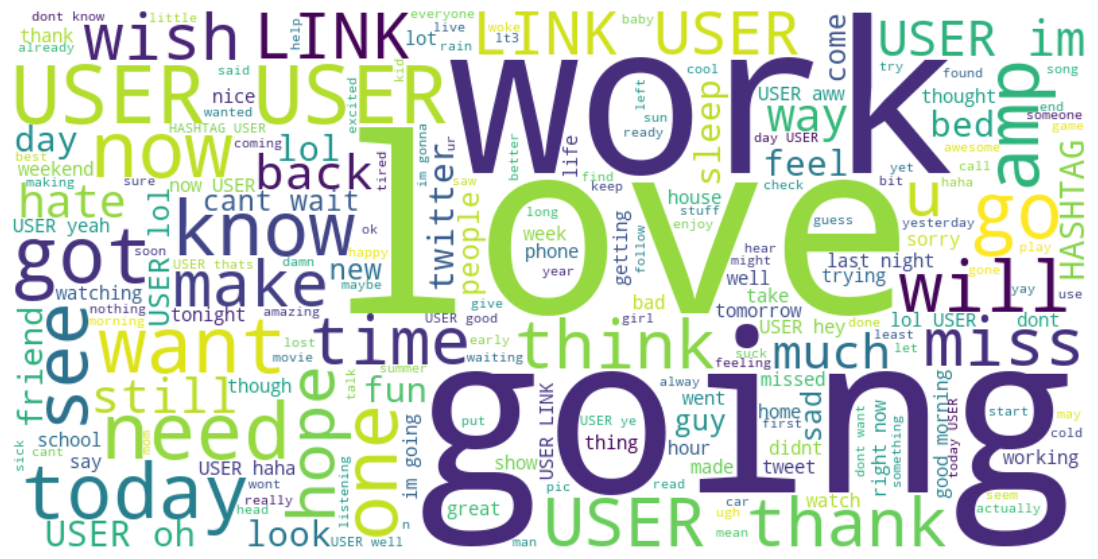

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned tweets into one string
text = " ".join(df['clean_text_no_punc'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()